#### Getting Started with FashionMNIST

This notebook shows how to load the FashionMNIST dataset in PyTorch and illustrates what kind of samples it contains.

In [3]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset

In [4]:
# create an instance of the training split of the FashionMNIST dataset
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, 
                             transform=ToTensor(), target_transform=lambda x: torch.Tensor([x]).int())
# now create an instance of the test split
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, 
                             transform=ToTensor(), target_transform=lambda x: torch.Tensor([x]).int())
# for our purposes we can combine the 60k training and 10k testing samples
dataset = ConcatDataset([dataset_train, dataset_valid])
# display some information on the dataset
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=2048,
                                          shuffle=True, num_workers=2)

print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


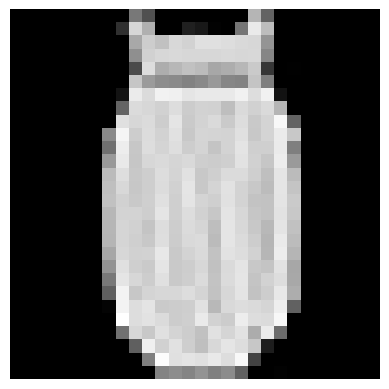

The image shows an instance of Shirt.


In [5]:
# we can also visualize and describe a sample
fig, ax = plt.subplots()
ax.imshow(img_tensor.squeeze(), cmap='Greys_r')
plt.axis('off')
plt.show()
print('The image shows an instance of ' + dataset_train.classes[class_label.item()] + '.')

In [6]:
# handvoll resisdual basic blocks -> flatten -> handvoll fully conntected layers
# resnet basic block : conv3x3 + norm_layer + non_lin + conv3x3 + normlayer
# identity: conv1x1 + norm layer
# output: non_lin(identity_layers(x) + [conv3x3 + norm_layer + non_lin + conv3x3 + normlayer](x))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv2 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc1 = nn.Linear(128 * 4, 128)
        #self.fc2 = nn.Linear(128, 84)
        #self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)



In [8]:
def ResNetWithParam(img_channel=1, num_classes=10):
    return ResNet(ResidualBlock, [2, 2, 2, 2], img_channel, num_classes)

In [9]:
def test():
    BATCH_SIZE = 2048
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNetWithParam(img_channel=1, num_classes=10).to(device)
    y = net(torch.randn(BATCH_SIZE, 1, 28, 28, device=device))
    assert y.size() == torch.Size([BATCH_SIZE, 10])
    print(y.size())

In [10]:
test()

torch.Size([2048, 10])


In [11]:
learning_rate = 0.01

model = ResNetWithParam(img_channel=1, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)

In [12]:
from tqdm.auto import tqdm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
    # get the inputs; data is a list of [inputs, labels]
        img_tensors, class_labels = [t.to(device) for t in data]
        class_labels = class_labels.squeeze(1).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(img_tensors)
        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
print('Finished Training')

19it [00:02,  8.71it/s]

[1,    20] loss: 0.790


30it [00:03,  7.90it/s]
20it [00:02,  7.03it/s]

[2,    20] loss: 0.681


30it [00:03,  7.56it/s]

Finished Training


Sneaker


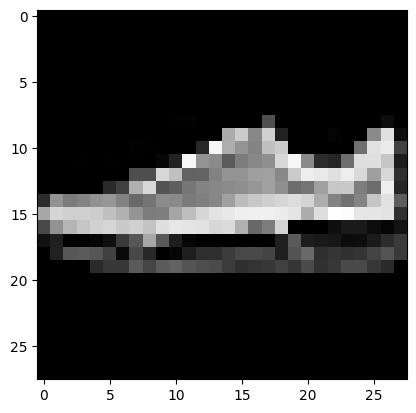

In [46]:
data_sample = dataset_valid.__getitem__(9)
inp_img, target = [t.to(device) for t in data_sample]
out = model(inp_img.unsqueeze(0))
print(dataset_valid.classes[out.argmax().cpu()])
plt.imshow(inp_img.squeeze().cpu(), cmap='Greys_r')
plt.show()